<a href="https://colab.research.google.com/github/Erickpython/kodeCamp_5X-MachineLearning/blob/main/Sequence_Models_Demo_%E2%80%94_From_Feedforward_to_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

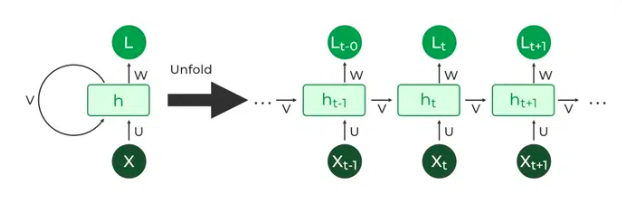

In [ ]:
# Original
orig_data = [1, 2, 3, 4, 5]


# Training data generated from this sequence
X = [], y = []
X.append([1]), y.append([2])
X.append([1, 2]), y.append([3])
X.append([1, 2, 3]), y.append([4])
X.append([1, 2, 3, 4]), y.append([5])

In [ ]:
# Only run if torch is missing
# !pip install torch matplotlib numpy

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)

## **Objective of this Experiment**

We will predict the next value of a noisy sine wave

Why this dataset?

- inherently sequential
- requires memory
- visually intuitive
- exposes RNN weaknesses

We will generate 50 timesteps of timeseries data. Model sees **50 timesteps** → predicts the **51st value**

## **Generate Time-Series Data**

In [ ]:
def generate_sine_data(seq_length=50, num_sequences=1000):

    X = []
    y = []

    for _ in range(num_sequences):
        start = np.random.rand() * 2 * np.pi
        steps = np.linspace(start, start + 3*np.pi, seq_length + 1)

        data = np.sin(steps) + np.random.normal(scale=0.1, size=len(steps))

        X.append(data[:-1])
        y.append(data[-1])

    return torch.tensor(X, dtype=torch.float32).unsqueeze(-1), \
           torch.tensor(y, dtype=torch.float32).unsqueeze(-1)


X, y = generate_sine_data()

print(X.shape)  # (1000, 50, 1)
print(y.shape)  # (1000, 1)

torch.Size([1000, 50, 1])
torch.Size([1000, 1])


/tmp/ipython-input-3009275228.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(X, dtype=torch.float32).unsqueeze(-1), \


## **Visualize a Sequence**

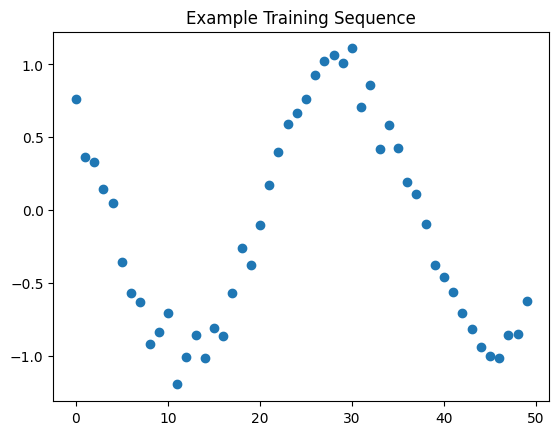

In [ ]:
for i in range(1):
    plt.plot(X[i].squeeze(), "o")
plt.title("Example Training Sequence")
plt.show()

## **Feedforward Network (No Memory)**

Let's deliberately build a **BAD** model. We use a feedforward network.

We flatten the sequence — destroying temporal structure.

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, seqlen):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(seqlen, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = x.squeeze(-1)  # flatten sequence
        return self.net(x)

In [ ]:
X.squeeze(-1).shape

torch.Size([1000, 50])

### **We are pretending order doesn’t matter.**

Watch what happens.

## **Training Function (Reusable)**

In [ ]:
def train_model(model, X, y, epochs=50):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
    loss_fn = nn.MSELoss()

    losses = []

    for epoch in range(epochs):

        preds = model(X)
        loss = loss_fn(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if epoch % 5 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

    return losses

In [ ]:
def calculate_accuracy(model, X, y):
    model.eval()
    with torch.no_grad():
        preds = model(X)

        preds = preds.squeeze()
        y = y.squeeze()

        accuracy = torch.mean(torch.abs(preds - y) / y)
        print(f"Accuracy: {accuracy.item() * 100:.2f}%")
        return accuracy

## **Train Feedforward**

In [ ]:
ff_model = FeedForward(50)
ff_losses = train_model(ff_model, X, y)

Epoch 0 | Loss: 0.4829
Epoch 5 | Loss: 0.0876
Epoch 10 | Loss: 0.0289
Epoch 15 | Loss: 0.0344
Epoch 20 | Loss: 0.0211
Epoch 25 | Loss: 0.0147
Epoch 30 | Loss: 0.0165
Epoch 35 | Loss: 0.0119
Epoch 40 | Loss: 0.0130
Epoch 45 | Loss: 0.0115
Epoch 49 | Loss: 0.0118


## **Plot Loss**

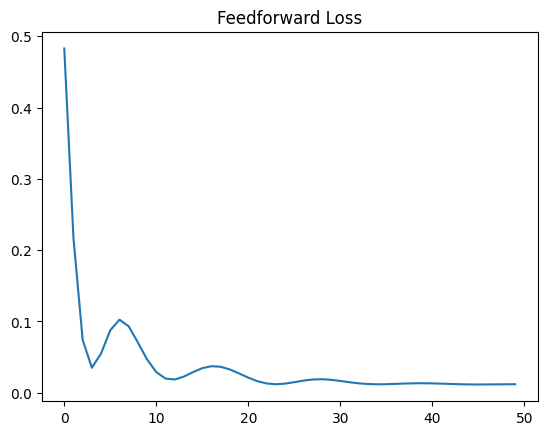

In [ ]:
plt.plot(ff_losses)
plt.title("Feedforward Loss")
plt.show()

Remember this curve. We are about to beat it easily.

## **Simple RNN**

Now introduce memory 🔥.

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=32,
            batch_first=True
        )

        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)
        return self.fc(hidden[-1])

Hidden state = memory

## **Train RNN**

In [ ]:
rnn_model = SimpleRNN()
rnn_losses = train_model(rnn_model, X, y)

Epoch 0 | Loss: 0.5355
Epoch 5 | Loss: 0.2586
Epoch 10 | Loss: 0.1298
Epoch 15 | Loss: 0.0603
Epoch 20 | Loss: 0.0264
Epoch 25 | Loss: 0.0345
Epoch 30 | Loss: 0.0251
Epoch 35 | Loss: 0.0234
Epoch 40 | Loss: 0.0219
Epoch 45 | Loss: 0.0191
Epoch 49 | Loss: 0.0190


## **Compare Loss**

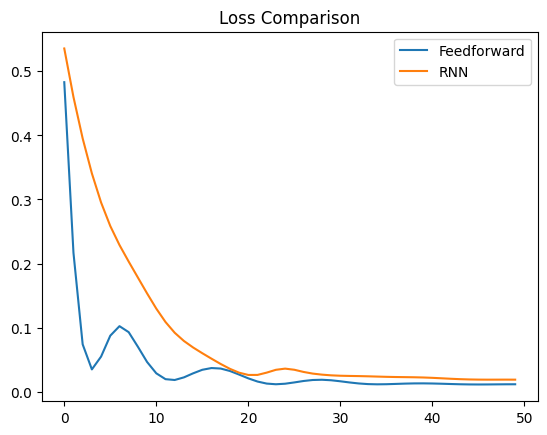

In [ ]:
plt.plot(ff_losses, label="Feedforward")
plt.plot(rnn_losses, label="RNN")
plt.legend()
plt.title("Loss Comparison")
plt.show()

> “Why is the RNN already better?”

Answer: **temporal awareness.**

## **Now we demonstrate RNN weakness.**

By increasing the sequence length.

## **Harder Dataset (Long Dependencies)**

In [ ]:
X_long, y_long = generate_sine_data(seq_length=240)


Now for very long series data, memory matters much more.

## **Train RNN on Long Data**

In [ ]:
ff_model = FeedForward(240)
ff_losses = train_model(ff_model, X_long, y_long)

Epoch 0 | Loss: 0.5629
Epoch 5 | Loss: 0.0558
Epoch 10 | Loss: 0.0127
Epoch 15 | Loss: 0.0173
Epoch 20 | Loss: 0.0343
Epoch 25 | Loss: 0.0191
Epoch 30 | Loss: 0.0099
Epoch 35 | Loss: 0.0127
Epoch 40 | Loss: 0.0123
Epoch 45 | Loss: 0.0097
Epoch 49 | Loss: 0.0098


In [ ]:
rnn_long = SimpleRNN()
rnn_long_losses = train_model(rnn_long, X_long, y_long)

Epoch 0 | Loss: 0.5799
Epoch 5 | Loss: 0.3297
Epoch 10 | Loss: 0.0848
Epoch 15 | Loss: 0.0507
Epoch 20 | Loss: 0.0338
Epoch 25 | Loss: 0.0214
Epoch 30 | Loss: 0.0225
Epoch 35 | Loss: 0.0180
Epoch 40 | Loss: 0.0182
Epoch 45 | Loss: 0.0173
Epoch 49 | Loss: 0.0169


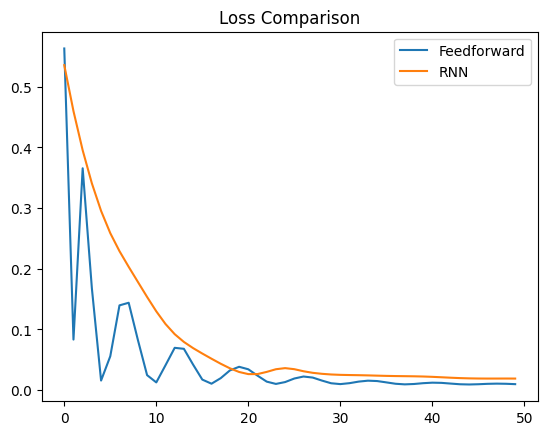

In [ ]:
plt.plot(ff_losses, label="Feedforward")
plt.plot(rnn_losses, label="RNN")
plt.legend()
plt.title("Loss Comparison")
plt.show()

You will typically see:

- slower convergence
- higher loss

Now you can see the limitation.


## **The Hero Model (LSTM)**

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=32,
            batch_first=True
        )

        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])

## **Train LSTM**

In [ ]:
lstm_model = LSTMModel()
lstm_losses = train_model(lstm_model, X_long, y_long)

Epoch 0 | Loss: 0.4895
Epoch 5 | Loss: 0.3726
Epoch 10 | Loss: 0.2328
Epoch 15 | Loss: 0.1235
Epoch 20 | Loss: 0.0679
Epoch 25 | Loss: 0.0481
Epoch 30 | Loss: 0.0363
Epoch 35 | Loss: 0.0273
Epoch 40 | Loss: 0.0220
Epoch 45 | Loss: 0.0193
Epoch 49 | Loss: 0.0172


## **Plot RNN vs LSTM**

Significant difference with long sequences.

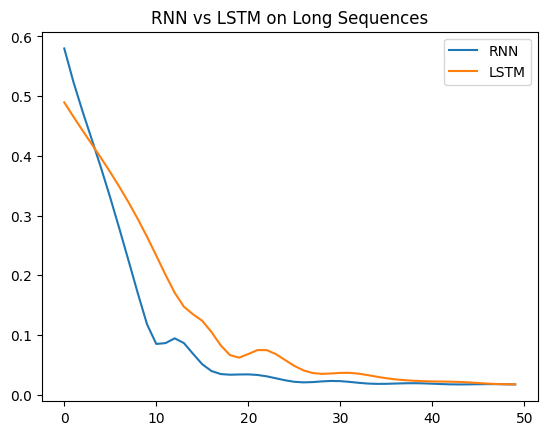

In [ ]:
plt.plot(rnn_long_losses, label="RNN")
plt.plot(lstm_losses, label="LSTM")
plt.legend()
plt.title("RNN vs LSTM on Long Sequences")
plt.show()

## **GRU**

Add GRU for a third comparison.

In [ ]:
class GRUModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.gru = nn.GRU(
            input_size=1,
            hidden_size=32,
            batch_first=True
        )

        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        _, hidden = self.gru(x)
        return self.fc(hidden[-1])

## **Train GRU**

In [ ]:
gru_model = GRUModel()
gru_losses = train_model(gru_model, X_long, y_long)

Epoch 0 | Loss: 0.5651
Epoch 5 | Loss: 0.3897
Epoch 10 | Loss: 0.2522
Epoch 15 | Loss: 0.1200
Epoch 20 | Loss: 0.0319
Epoch 25 | Loss: 0.0496
Epoch 30 | Loss: 0.0287
Epoch 35 | Loss: 0.0203
Epoch 40 | Loss: 0.0222
Epoch 45 | Loss: 0.0194
Epoch 49 | Loss: 0.0166


## **Final Comparison**

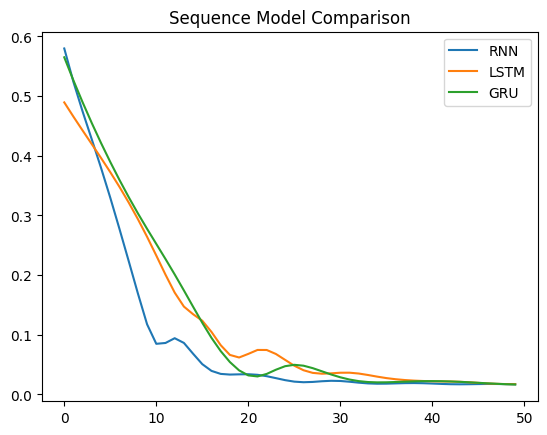

In [ ]:
plt.plot(rnn_long_losses, label="RNN")
plt.plot(lstm_losses, label="LSTM")
plt.plot(gru_losses, label="GRU")

plt.legend()
plt.title("Sequence Model Comparison")
plt.show()

### **Why might GRU be preferred in production?**

- fewer parameters
- faster
- similar accuracy

## **Predict and Visualize**

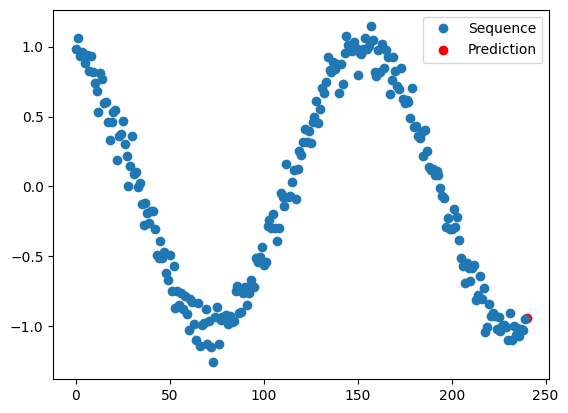

In [ ]:
test_seq = X_long[0].unsqueeze(0)

pred = lstm_model(test_seq).item()

plt.plot(test_seq.squeeze(), "o", label="Sequence")
plt.scatter(len(test_seq.squeeze()), pred, color="red", label="Prediction")
plt.legend()
plt.show()